# CNN Dog Breed Classication

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. This dataset is being imported from the official page from Stanford

The contents of the dataset are:

 - **Number of categories**: 120
 - **Number of images**: 20,580
 - **Image Dimensions**: (256,256)

Since there are only about 170 images per category. It would be beneficial to use transfer learning.
We will be using the pre-trained model Inception V3 which has been trained on 'imagenet'. The weights will be freezed, and then we will create new layers to get the desired output

## Libraries and Config

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

2024-05-29 07:59:58.087136: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 07:59:58.251379: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 07:59:58.932387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 08:00:00.543231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.16.1'

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 256
CHANNELS = 3

## Transfer Learning


Inception v3 is a highly efficient convolutional neural network renowned for its depth and exceptional performance in image classification tasks. Its innovative design incorporates factorized convolutions and regularization techniques, making it well-suited for transfer learning. Leveraging pre-trained weights from datasets like ImageNet, Inception v3 enables effective fine-tuning on domain-specific data, playing a pivotal role in various computer vision applications.

In [23]:
# Load the InceptionV3 model
inception = tf.keras.applications.InceptionV3(
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    include_top=False, 
    weights='imagenet')
# Freeze the pre-trained model weights
inception.trainable = False

Get the class names from a breed txt file in the same order of the one hot encoding 

In [13]:
def class_names_txt(filepath):
    """
    Read a text file and save each line as an element in a list.
    """
    names = []
    with open(filepath, 'r') as file:
        for line in file:
            # Remove newline characters and any trailing/leading whitespaces
            cleaned_line = line.strip()
            cleaned_line = cleaned_line.replace("'", "")
            cleaned_line = cleaned_line.replace(",", "")
            names.append(cleaned_line)
    return names

filepath = "Dataset/breeds.txt"  
class_names = class_names_txt(filepath)

## Data Augmentation

Now we set up the image data augmentation and generators for training and validation in a convolutional neural network (CNN) model using TensorFlow and Keras. It rescales, rotates, zooms, and flips images for augmentation. Then, it generates batches of training and validation images from a specified directory, resizing them to a target size and categorizing them based on class mode. Finally, it prints the sizes of the training and validation datasets to confirm the number of images available for model training and evaluation.

In [14]:
# Dir with the dataset
train_data_dir = './Dataset/Images/'
# Data augmentation
train_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
                                   rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range = 15,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)

# Flow training images in batches of 256 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') 

# Flow validation images in batches of 256 using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, #mini-batches of size 512 images
    class_mode='categorical',
    subset='validation')

# Number of images in the training and validation sets
TRAIN_SIZE = train_generator.samples
VALIDATION_SIZE = validation_generator.samples
print("Train size: ", TRAIN_SIZE)
print("Validation size: ", VALIDATION_SIZE)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Train size:  16508
Validation size:  4072


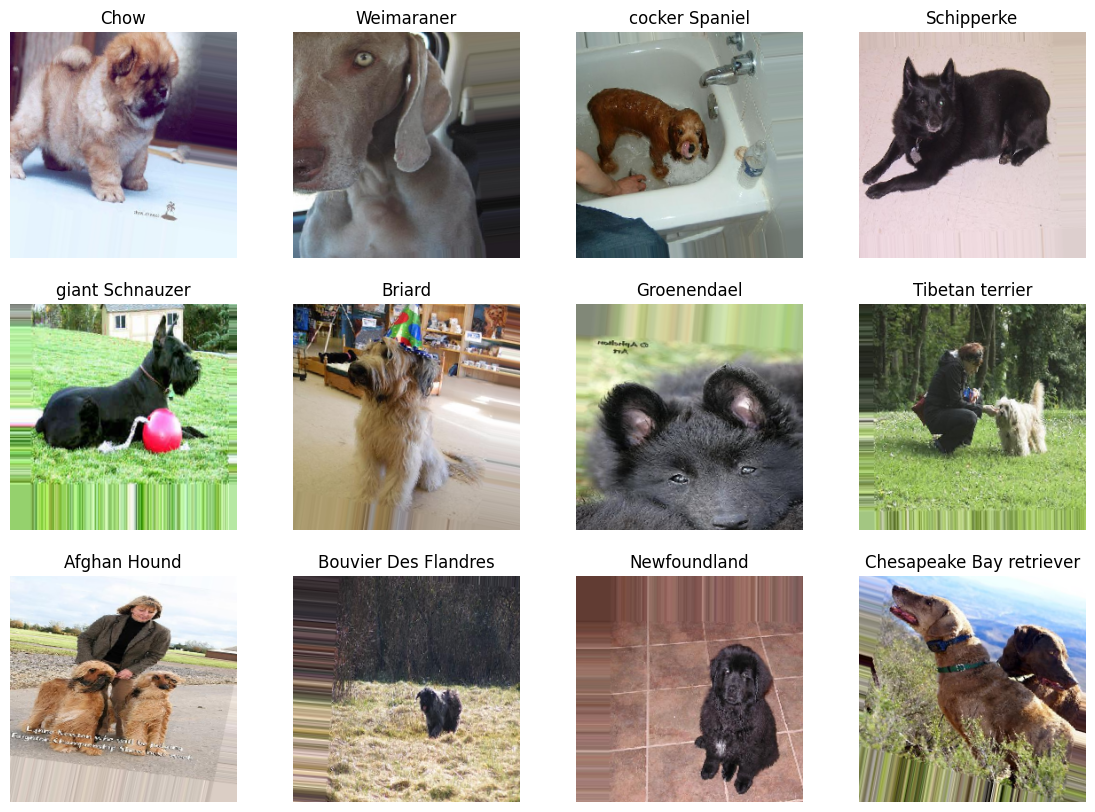

In [6]:
# Create plot to show some images
plt.figure(figsize=(14, 10))
# Get the first batch of images from the generator
images, labels = next(train_generator)
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## Model

In [41]:
# Create the model
model = tf.keras.Sequential([
                             inception, #inception layer
                             tf.keras.layers.GlobalAveragePooling2D(), #GlobalAveragePooling2D layer
                             tf.keras.layers.Flatten(), # Flatten layer
                             tf.keras.layers.Dropout(rate=0.2), #Dropout layer
                             tf.keras.layers.Dense(240,activation='relu'), # Dense layer
                             tf.keras.layers.Dropout(rate=0.1), #Dropout layer
                             tf.keras.layers.Dense(240,activation = 'relu'), # Dense layer
                             tf.keras.layers.Dropout(rate=0), #Dropout layer
                             tf.keras.layers.Dense(120,activation = 'softmax') # Output layer
                             
])

In [42]:
# Optimizer and loss function
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.99)
# Compile the model
model.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# Define the number of epochs
EPOCHS = 20
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE),
    validation_data = validation_generator, 
    validation_steps = int(VALIDATION_SIZE/BATCH_SIZE),
    epochs = EPOCHS)

## Model Results

In [45]:
# Get the keys of the history object
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
# Get the accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Get the loss and val_loss
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

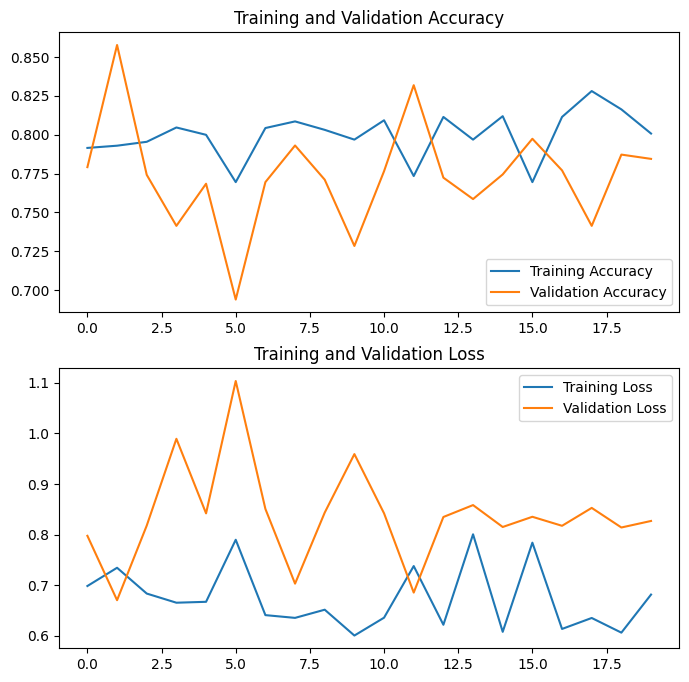

In [47]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(8, 8))
# Accuracy
plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
# Loss
plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# Add labels
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step


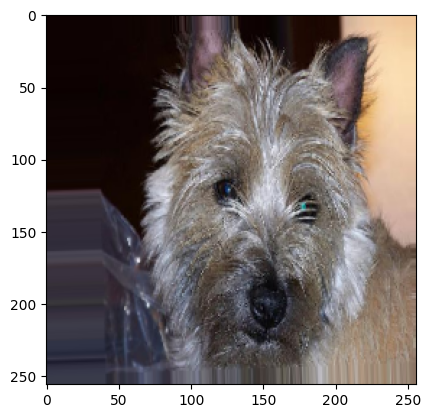

Predicted label:  Cairn Terrier
Actual label:  Cairn Terrier


In [70]:
# Get the first batch of images from the generator
images_val, labels_val = next(validation_generator)
# Predict the labels of the images
labels_predict = model.predict(images_val)
# Generate a random number
random_int = np.random.randint(0, BATCH_SIZE)
# Get the predicted and actual label
predicted_label = class_names[np.argmax(labels_predict[random_int])]
actual_label = class_names[np.argmax(labels_val[random_int])]
# Plot the image
plt.imshow(images_val[random_int])
plt.show()
# Print the predicted and actual label
print("Predicted label: ", predicted_label)
print("Actual label: ", actual_label)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 710ms/step


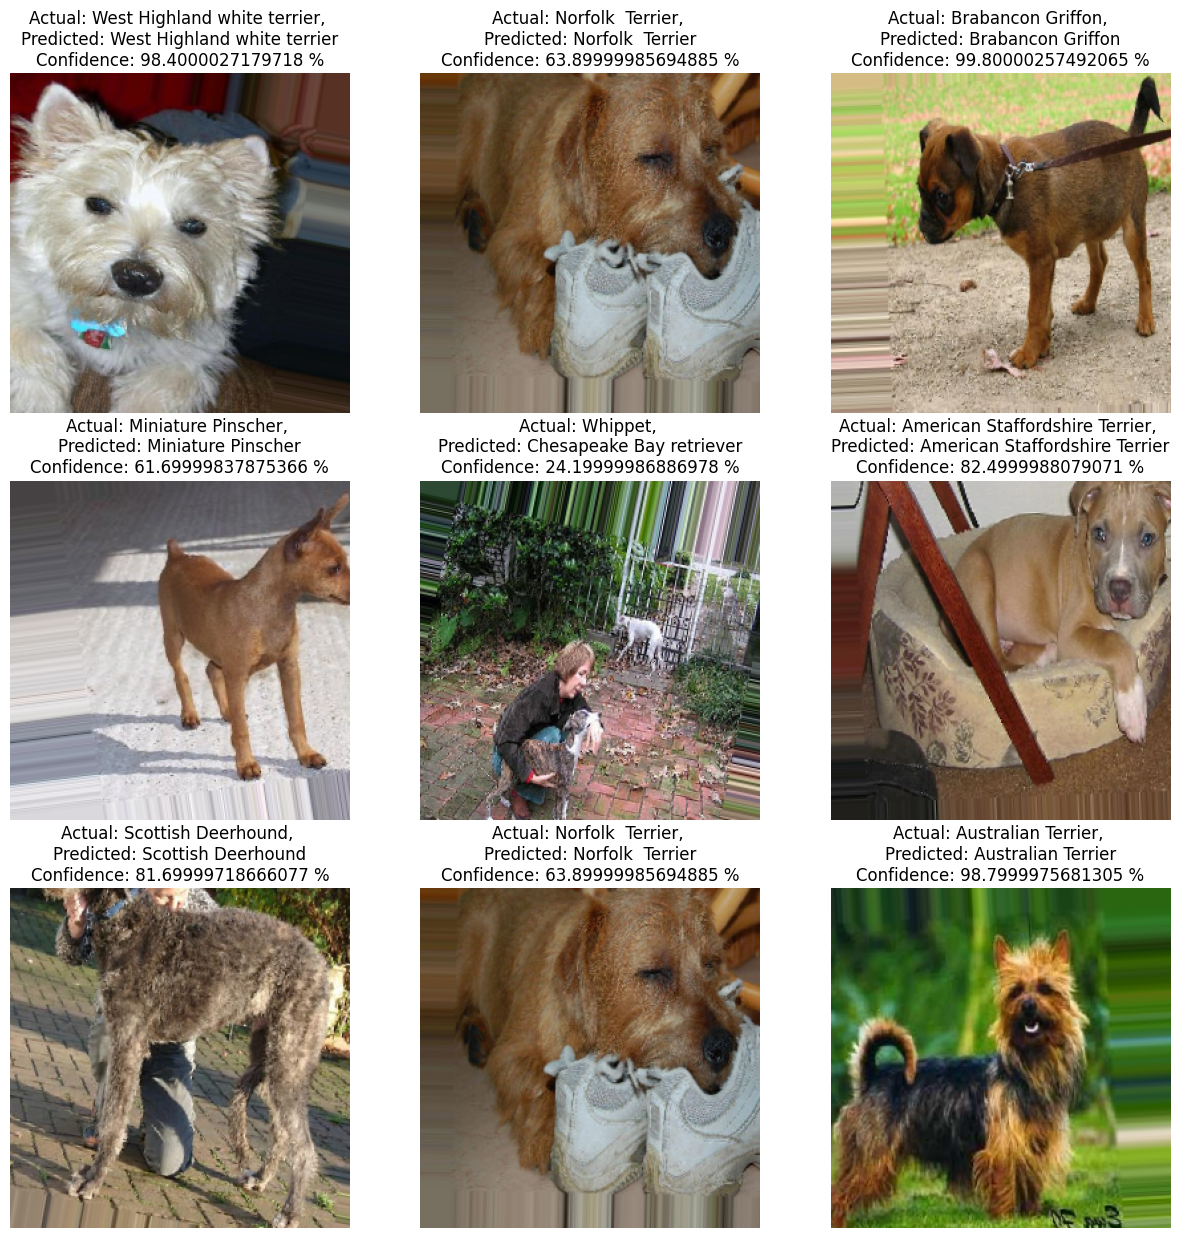

In [84]:
# Plot the first 9 images in the validation set
images_val, labels_val = next(validation_generator)
labels_predict = model.predict(images_val)
# Create a plot with 3x3 subplots
plt.figure(figsize=(15, 15))
for i in range(9):
    # Add subplots
    plt.subplot(3, 3, i + 1)
    # Generate a random number
    random_int = np.random.randint(0, len(images_val))
    # Get the predicted and actual label
    predicted_label = class_names[np.argmax(labels_predict[random_int])]
    actual_label = class_names[np.argmax(labels_val[random_int])]
    # Get the confidence of the model
    confidence = 100* round(labels_predict[random_int][np.argmax(labels_predict[random_int])], 3)
    # Plot the image
    plt.imshow(images_val[random_int])
    plt.title(f"Actual: {actual_label}, \nPredicted: {predicted_label}\nConfidence: {confidence} %")
    plt.axis("off")

In [49]:
# Save the model
model_version = "SGD-0.01-0.99-20epochs"
model.save(f"./models/{model_version}.keras")

# InceptionResNetV2

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

2024-05-29 09:55:56.094453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 09:55:57.173847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.16.1'

In [5]:
print(tf.config.list_physical_devices('GPU'))

[]


In [7]:
# Load the InceptionV3 model
inception = tf.keras.applications.InceptionResNetV2(
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    include_top=False)
# Freeze the pre-trained model weights
inception.trainable = False

In [8]:
# Create the model
model = tf.keras.Sequential([
                             inception, #inception layer
                             tf.keras.layers.GlobalAveragePooling2D(), #GlobalAveragePooling2D layer
                             tf.keras.layers.Flatten(), # Flatten layer
                             tf.keras.layers.Dropout(rate=0.2), #Dropout layer
                             tf.keras.layers.Dense(120,activation='relu'), # Dense layer
                             tf.keras.layers.Dropout(rate=0.1), #Dropout layer
                             tf.keras.layers.Dense(120,activation = 'relu'), # Dense layer
                             tf.keras.layers.Dropout(rate=0), #Dropout layer
                             tf.keras.layers.Dense(120,activation = 'softmax') # Output layer
                             
])

In [9]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model.build(input_shape)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (256, 6, 6, 1536)      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (256, 1536)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (256, 1536)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 1536)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 120)             │       184,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (256, 120)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (256, 120)             │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (256, 120)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (256, 120)             │        14,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,550,216 (208.09 MB)

 Trainable params: 213,480 (833.91 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE),
    validation_data = validation_generator, 
    validation_steps = int(VALIDATION_SIZE/BATCH_SIZE),
    epochs = EPOCHS)

Epoch 1/20


/home/tavera/projects/dog_breed_cnn/venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/tavera/projects/dog_breed_cnn/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-29 09:58:28.172862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-05-29 09:58:42.950545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

64/64 ━━━━━━━━━━━━━━━━━━━━ 1476s 22s/step - accuracy: 0.3210 - loss: 3.4602 - val_accuracy: 0.8104 - val_loss: 0.6919
Epoch 2/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 23:14 22s/step - accuracy: 0.8281 - loss: 0.6937

2024-05-29 10:22:47.668077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-29 10:23:05.531895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - accuracy: 0.8281 - loss: 0.6937 - val_accuracy: 0.8491 - val_loss: 0.5602
Epoch 3/20


2024-05-29 10:23:17.074250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 10:23:28.766001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1497s 23s/step - accuracy: 0.8171 - loss: 0.7096 - val_accuracy: 0.8299 - val_loss: 0.6126
Epoch 4/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 19:21 18s/step - accuracy: 0.8594 - loss: 0.5537

2024-05-29 10:48:21.207935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.8594 - loss: 0.5537 - val_accuracy: 0.8362 - val_loss: 0.6486
Epoch 5/20


2024-05-29 10:48:37.455415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 10:48:48.211410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 10:48:58.827455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1498s 23s/step - accuracy: 0.8203 - loss: 0.6450 - val_accuracy: 0.8315 - val_loss: 0.5929
Epoch 6/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 19:48 19s/step - accuracy: 0.8125 - loss: 0.7311

2024-05-29 11:13:54.555987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 11:14:12.899530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 295ms/step - accuracy: 0.8125 - loss: 0.7311 - val_accuracy: 0.8319 - val_loss: 0.6196
Epoch 7/20


2024-05-29 11:14:24.160589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 11:14:35.814139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1509s 23s/step - accuracy: 0.8319 - loss: 0.5916 - val_accuracy: 0.8367 - val_loss: 0.5932
Epoch 8/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 18:46 18s/step - accuracy: 0.8281 - loss: 0.6960

2024-05-29 11:39:40.037718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.8281 - loss: 0.6960 - val_accuracy: 0.8578 - val_loss: 0.4692
Epoch 9/20


2024-05-29 11:39:56.828692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 11:40:07.935160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 11:40:18.681148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1500s 23s/step - accuracy: 0.8318 - loss: 0.5841 - val_accuracy: 0.8424 - val_loss: 0.5844
Epoch 10/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 19:59 19s/step - accuracy: 0.7852 - loss: 0.6121

2024-05-29 12:05:15.802498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 273ms/step - accuracy: 0.7852 - loss: 0.6121 - val_accuracy: 0.8664 - val_loss: 0.4647
Epoch 11/20


2024-05-29 12:05:32.924043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 12:05:44.330669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 12:05:55.411680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1585s 25s/step - accuracy: 0.8323 - loss: 0.5725 - val_accuracy: 0.8320 - val_loss: 0.5752
Epoch 12/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 20:52 20s/step - accuracy: 0.8477 - loss: 0.5214

2024-05-29 12:32:17.628955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - accuracy: 0.8477 - loss: 0.5214 - val_accuracy: 0.8319 - val_loss: 0.7013
Epoch 13/20


2024-05-29 12:32:35.793471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 12:32:47.339524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 12:32:58.673614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1701s 26s/step - accuracy: 0.8357 - loss: 0.5515 - val_accuracy: 0.8375 - val_loss: 0.5716
Epoch 14/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 10:54 10s/step - accuracy: 0.8710 - loss: 0.4041

2024-05-29 13:01:07.056456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - accuracy: 0.8710 - loss: 0.4041 - val_accuracy: 0.8147 - val_loss: 0.6172
Epoch 15/20


2024-05-29 13:01:26.516625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 13:01:39.228359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 13:01:51.497491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1588s 24s/step - accuracy: 0.8416 - loss: 0.5295 - val_accuracy: 0.8411 - val_loss: 0.5419
Epoch 16/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 21:06 20s/step - accuracy: 0.8398 - loss: 0.5767

2024-05-29 13:28:14.469284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 282ms/step - accuracy: 0.8398 - loss: 0.5767 - val_accuracy: 0.8017 - val_loss: 0.7141
Epoch 17/20


2024-05-29 13:28:32.195257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 13:28:43.628186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 13:28:54.598414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1573s 24s/step - accuracy: 0.8431 - loss: 0.5241 - val_accuracy: 0.8445 - val_loss: 0.5611
Epoch 18/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 19:38 19s/step - accuracy: 0.8555 - loss: 0.5366

2024-05-29 13:55:04.137183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.8555 - loss: 0.5366 - val_accuracy: 0.8362 - val_loss: 0.4565
Epoch 19/20


2024-05-29 13:55:20.842325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-29 13:55:31.881365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-29 13:55:42.797199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1547s 24s/step - accuracy: 0.8429 - loss: 0.5221 - val_accuracy: 0.8362 - val_loss: 0.5645
Epoch 20/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 19:34 19s/step - accuracy: 0.8281 - loss: 0.6076

2024-05-29 14:21:26.574448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 265ms/step - accuracy: 0.8281 - loss: 0.6076 - val_accuracy: 0.8103 - val_loss: 0.7598


2024-05-29 14:21:43.209522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [16]:
# Get the accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Get the loss and val_loss
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

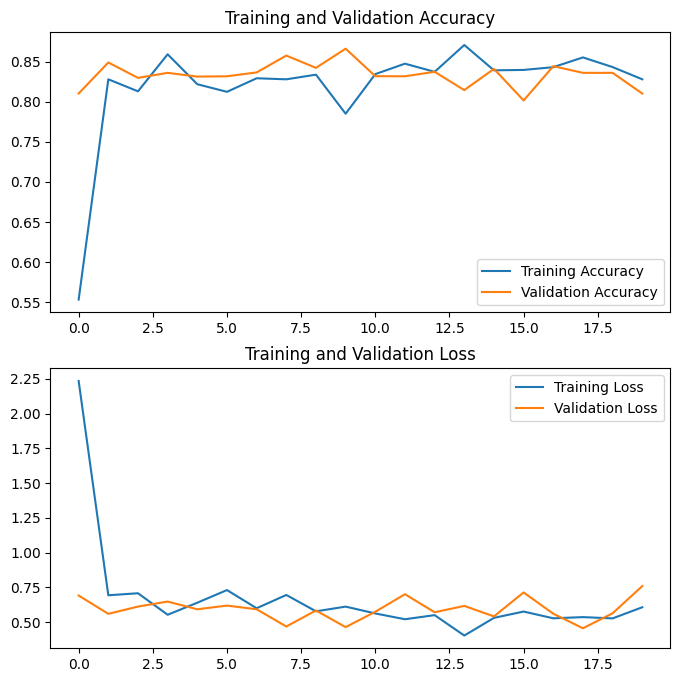

In [17]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(8, 8))
# Accuracy
plt.subplot(2, 1, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
# Loss
plt.subplot(2, 1, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# Add labels
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


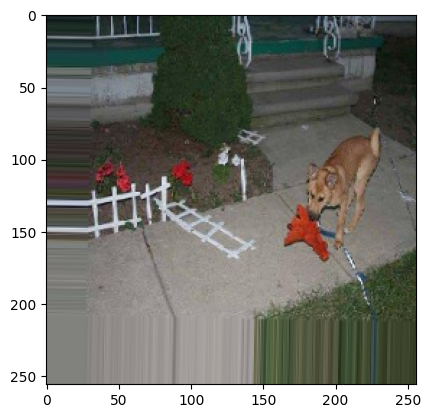

Predicted label:  Basenji
Actual label:  Basenji


In [18]:
# Get the first batch of images from the generator
images_val, labels_val = next(validation_generator)
# Predict the labels of the images
labels_predict = model.predict(images_val)
# Generate a random number
random_int = np.random.randint(0, BATCH_SIZE)
# Get the predicted and actual label
predicted_label = class_names[np.argmax(labels_predict[random_int])]
actual_label = class_names[np.argmax(labels_val[random_int])]
# Plot the image
plt.imshow(images_val[random_int])
plt.show()
# Print the predicted and actual label
print("Predicted label: ", predicted_label)
print("Actual label: ", actual_label)

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


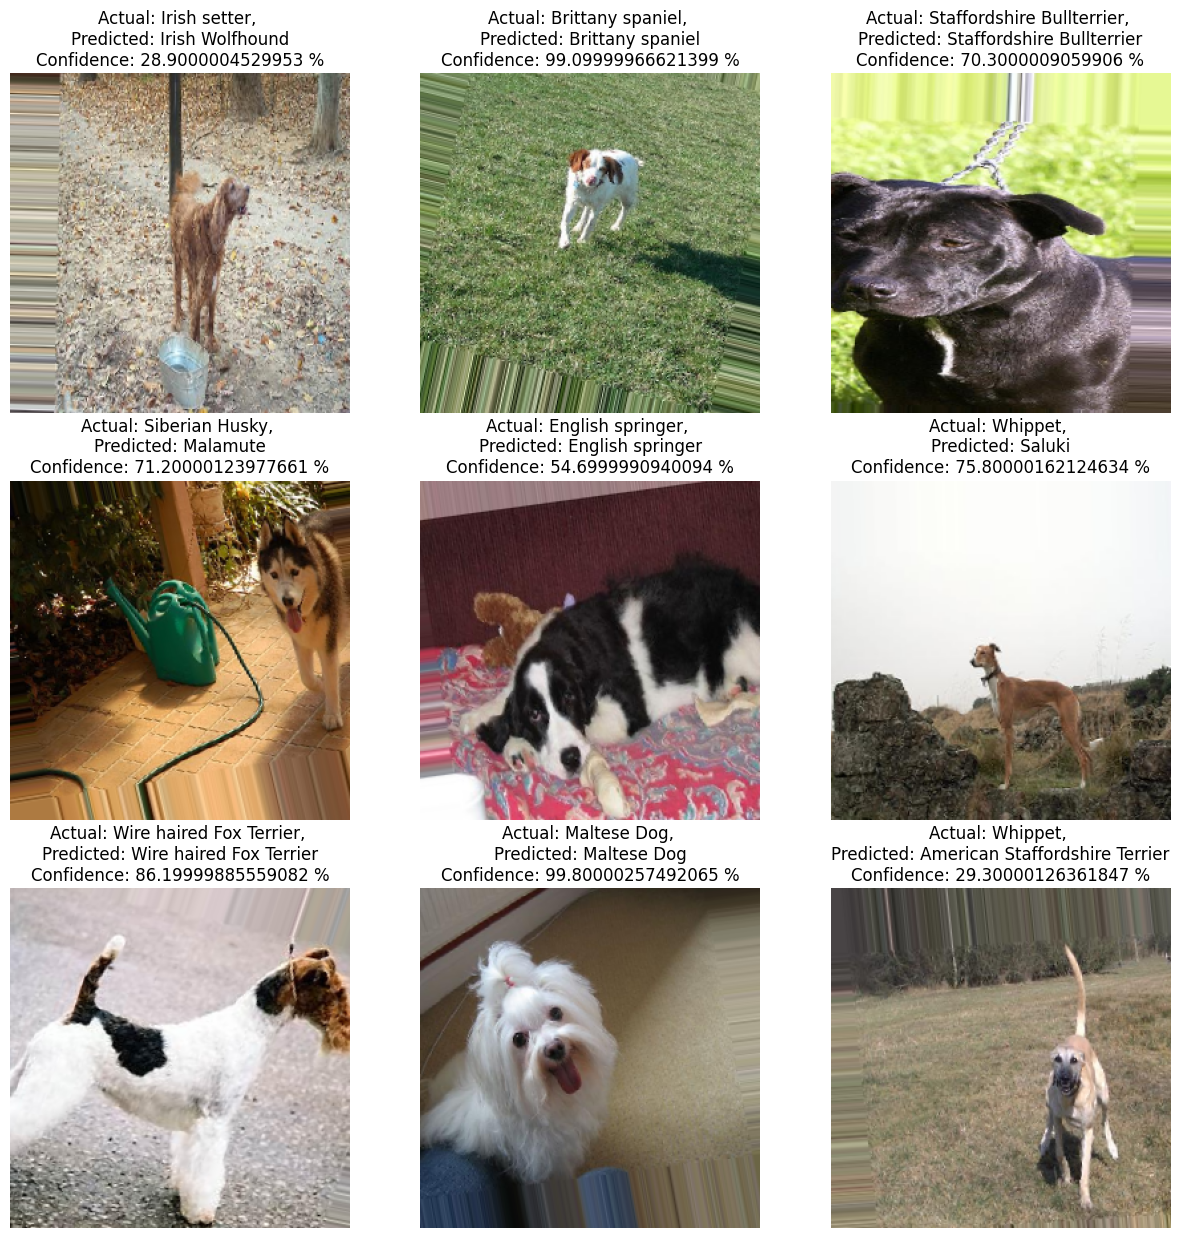

In [19]:
# Plot the first 9 images in the validation set
images_val, labels_val = next(validation_generator)
labels_predict = model.predict(images_val)
# Create a plot with 3x3 subplots
plt.figure(figsize=(15, 15))
for i in range(9):
    # Add subplots
    plt.subplot(3, 3, i + 1)
    # Generate a random number
    random_int = np.random.randint(0, len(images_val))
    # Get the predicted and actual label
    predicted_label = class_names[np.argmax(labels_predict[random_int])]
    actual_label = class_names[np.argmax(labels_val[random_int])]
    # Get the confidence of the model
    confidence = 100* round(labels_predict[random_int][np.argmax(labels_predict[random_int])], 3)
    # Plot the image
    plt.imshow(images_val[random_int])
    plt.title(f"Actual: {actual_label}, \nPredicted: {predicted_label}\nConfidence: {confidence} %")
    plt.axis("off")

In [20]:
# Save the model
model_version = "inceptionresnetv2_adam-20epochs"
model.save(f"./models/{model_version}.keras")